<a href="https://colab.research.google.com/github/frontenddima/Animocons/blob/master/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_7_%D0%A0%D0%B5%D1%87%D1%8C_%D0%B2_%D1%82%D0%B5%D0%BA%D1%81%D1%82__DeepSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://lk.neural-university.ru/lesson/510

In [ ]:
!pip install git+https://github.com/librosa/librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/librosa/librosa to /tmp/pip-req-build-pxgnl42l
  Running command git clone -q https://github.com/librosa/librosa /tmp/pip-req-build-pxgnl42l
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 /usr/local/lib/python3.8/dist-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmpwdcvjslh Check the logs for full command output.


In [ ]:
import tarfile
import pandas as pd
import os
import librosa
import scipy
import numpy as np
from numpy.lib.stride_tricks import as_strided
from IPython.display import Audio

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, BatchNormalization, ZeroPadding1D, Conv1D, TimeDistributed, Dense, Bidirectional, GRU, Lambda
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#GPU Info

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
 print("GPU Model: ", gpu.name)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=b796424ce990ef4cd49ced0f4184437a8a2bee378e9062ae5a8c41923ef225ac
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
printm()

Gen RAM Free: 12.6 GB  | Proc size: 624.1 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB
GPU Model:  Tesla T4


#Prepare char map

In [ ]:
# Alphabet + space + unknown
char_map_str = """
<SPACE> 0
а 1
б 2
в 3
г 4
д 5
е 6
ё 7
ж 8
з 9
и 10
й 11
к 12
л 13
м 14
н 15
о 16
п 17
р 18
с 19
т 20
у 21
ф 22
х 23
ц 24
ч 25
ш 26
щ 27
ъ 28
ы 29
ь 30
э 31
ю 32
я 33
' 34
"""

char_map = {}
index_map = {}

for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch

index_map[0] = ' '

def text_to_int_sequence(text):
    """ Use a character map and convert text to an integer sequence """
    int_sequence = []
    for c in text.lower():
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

In [ ]:
#How it works:
print("char_map:", char_map)
print("index map:", index_map)
privet = "Привет"
print(privet+": ", text_to_int_sequence(privet))

char_map: {'<SPACE>': 0, 'а': 1, 'б': 2, 'в': 3, 'г': 4, 'д': 5, 'е': 6, 'ё': 7, 'ж': 8, 'з': 9, 'и': 10, 'й': 11, 'к': 12, 'л': 13, 'м': 14, 'н': 15, 'о': 16, 'п': 17, 'р': 18, 'с': 19, 'т': 20, 'у': 21, 'ф': 22, 'х': 23, 'ц': 24, 'ч': 25, 'ш': 26, 'щ': 27, 'ъ': 28, 'ы': 29, 'ь': 30, 'э': 31, 'ю': 32, 'я': 33, "'": 34}
index map: {0: ' ', 1: 'а', 2: 'б', 3: 'в', 4: 'г', 5: 'д', 6: 'е', 7: 'ё', 8: 'ж', 9: 'з', 10: 'и', 11: 'й', 12: 'к', 13: 'л', 14: 'м', 15: 'н', 16: 'о', 17: 'п', 18: 'р', 19: 'с', 20: 'т', 21: 'у', 22: 'ф', 23: 'х', 24: 'ц', 25: 'ч', 26: 'ш', 27: 'щ', 28: 'ъ', 29: 'ы', 30: 'ь', 31: 'э', 32: 'ю', 33: 'я', 34: "'"}
Привет:  [17, 18, 10, 3, 6, 20]


#Import Data

In [ ]:
#Preparing DataFrame
def combine_all_wavs_and_trans_from_csvs(csvslist, sortagrad=True, createwordlist=False, delBigTranscripts=True):
    '''Assume that data is in csv already exists with data in form
        path, size, transcript
        this is best approach for loading in moz deepspeech processed files.
    '''

    df_all = pd.DataFrame()

    #Reading all tsv (same as csv, but TAB separated)
    for csv in csvslist.split(','):
        if os.path.isfile(csv):
            df_new = pd.read_csv(csv, sep='\t', encoding='utf-8')
            df_all = df_all.append(df_new)

    #Removing word "Firefox"
    df_all = df_all[df_all['sentence'] != "Firefox"]

    #Removing long words
    if delBigTranscripts:
        df_final = df_all[df_all['sentence'].map(len) <= 40]
    else:
        df_final = df_all

    # can output the word list here if required
    if createwordlist:
        df_final['sentence'].to_csv("./DeepSpeech/df_all_word_list.csv", sep=',', header=False, index=False)  # reorder + out

    return df_final

def get_number_of_char_classes():
    ## would be better to check with dataset (once cleaned)
    num_classes = len(char_map)+1 ##need +1 for ctc null char +1 pad
    return num_classes

#Spectrogram processor

In [ ]:
spectrogram_cache = {}

##############################################################################

def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram
    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).
    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x
    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """

    if filename in spectrogram_cache:
      return spectrogram_cache[filename]


    audio, sample_rate = librosa.load(filename, sr=16000)
    max_freq = sample_rate / 2
    if step > window:
      raise ValueError("step size must not be greater than window size")
    hop_length = int(0.001 * step * sample_rate)
    fft_length = int(0.001 * window * sample_rate)
    pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    spg = np.transpose(np.log(pxx[:ind, :] + eps))
    spectrogram_cache[filename] = spg
    return spg

#Batch generator

In [ ]:
class BatchGenerator(object):
    def __init__(self, dataframe, batch_size):
        self.df = dataframe.copy()
        self.wavpath  = [soundfile_path + filepath for filepath in self.df['path'].tolist()]
        self.transcript = self.df['sentence'].tolist()
        self.batch_size = batch_size
        self.cur_index = 0

        assert (self.batch_size <= len(self.wavpath))

        #Free up memory of unneeded data
        del dataframe
        #self.df = None
        del self.df

    def get_batch(self, idx):

        #select files
        batch_x = self.wavpath[idx * self.batch_size:(idx + 1) * self.batch_size]

        #select transcriptions
        batch_y_trans = self.transcript[idx * self.batch_size:(idx + 1) * self.batch_size]

        #Calculate longest spectrogram
        x_val = [get_max_specto_time(file_name) for file_name in batch_x]
        max_val = max(x_val)

        #Prepare spectrograms with shape aligned to longest
        X_data = np.array([make_specto_shape(file_name, padlen=max_val) for file_name in batch_x])

        #longest transcription
        y_val = [get_maxseq_len(l) for l in batch_y_trans]
        max_y = max(y_val)

        #prepare labels aligned to longest
        labels = np.array([get_intseq(l, max_intseq_length = max_y) for l in batch_y_trans])

        input_length = np.array(x_val)
        label_length = np.array(y_val)

        # source_str (used for human readable output on callback)
        # Just for callbacks
        source_str = np.array([l for l in batch_y_trans])

        #Model input
        inputs = {
            'the_input': X_data,
            'the_labels': labels,
            'input_length': input_length,
            'label_length': label_length,
            'source_str': source_str
        }

        #print("get_batch idx = ", idx)
        #print("_____________inputs________________")
        #print("(X_data) the_input.shape", X_data.shape)
        #print("(labels) the_labels:", inputs['the_labels'])
        #print("(input_length) input_length:", inputs['input_length'])
        #print("(label_length) label_length:", inputs['label_length'])
        #print("(source_str) source_str:", inputs['source_str'])

        #Setting output to zero because model output is loss
        outputs = {'ctc': np.zeros([self.batch_size])}
        #print("outputs: ", outputs['ctc'])

        return (inputs, outputs)

    def next_batch(self):

        #infinite iterations
        while 1:
            if (self.cur_index + 1) * self.batch_size >= len(self.wavpath) - self.batch_size:
                self.cur_index = 0

            ret = self.get_batch(self.cur_index)

            self.cur_index += 1

            yield ret

#same as len(trans). But in case of bigrams is not equal to len(trans)
def get_maxseq_len(trans):
    # PAD
    t = text_to_int_sequence(trans)
    return len(t)

def get_intseq(trans, max_intseq_length=80):
    # PAD
    t = text_to_int_sequence(trans)
    while (len(t) < max_intseq_length):
        t.append(34)  # replace with a space char to pad
    return t


def get_max_specto_time(filename):
    r = spectrogram_from_file(filename)
    return r.shape[0]  #


def make_specto_shape(filename, padlen=778):
    r = spectrogram_from_file(filename)
    t = np.transpose(r)  # 2D array ->  spec x timesamples
    X = pad_sequences(t, maxlen=padlen, dtype='float', padding='post', truncating='post').T
    return X  # MAXtimesamples x specto {max x 161}

In [ ]:
print("get_maxseq_len('Привет')", get_maxseq_len("Привет"))
print("get_intseq('Привет')", get_intseq("Привет"))

get_maxseq_len('Привет') 6
get_intseq('Привет') [17, 18, 10, 3, 6, 20, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]


#Model

In [ ]:
# Define CTC loss
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def clipped_relu(x):
    return relu(x, max_value=20)

def ds2_gru_model(input_dim=161, fc_size=1024, rnn_size=512, output_dim=29, initialization='glorot_uniform',
                  conv_layers=1, gru_layers=4, use_conv=True):
    """ DeepSpeech 2 implementation
    Architecture:
        Input Spectrogram TIMEx161
        1 Batch Normalisation layer on input
        1-3 Convolutional Layers
        1 Batch Normalisation layer
        1-7 BiDirectional GRU Layers
        1 Batch Normalisation layer
        1 Fully connected Dense
        1 Softmax output
    Details:
       - Uses Spectrogram as input rather than MFCC
       - Did not use BN on the first input
       - Network does not dynamically adapt to maximum audio size in the first convolutional layer. Max conv
          length padded at 2048 chars, otherwise use_conv=False
    Reference:
        https://arxiv.org/abs/1512.02595
    """

    input_data = Input(shape=(None, input_dim), name='the_input') #<-Spectrograms with 161 freqs
    x = BatchNormalization()(input_data)

    if use_conv:
        conv = ZeroPadding1D(padding=(0, 2048))(x)
        for l in range(conv_layers):
            x = Conv1D(filters=fc_size, name='conv_{}'.format(l+1), kernel_size=11, padding='valid', activation='relu', strides=2)(conv)
    else:
        for l in range(conv_layers):
            x = TimeDistributed(Dense(fc_size, name='fc_{}'.format(l + 1), activation='relu'))(x)  # >>(?, time, fc_size)

    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    for l in range(gru_layers):
        #x = Bidirectional(
        #        layer = GRU(rnn_size, name='gru_{}'.format(l + 1), return_sequences=True, activation='relu', kernel_initializer=initialization),
        #        merge_mode='sum')(x)
        x = Bidirectional(
                layer = CuDNNGRU(rnn_size, name='gru_{}'.format(l + 1), return_sequences=True),
                merge_mode='sum')(x)

    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    # Last Layer 5+6 Time Dist Dense Layer & Softmax
    x = TimeDistributed(Dense(fc_size, activation=clipped_relu))(x)
    y_pred = TimeDistributed(Dense(output_dim, name="y_pred", activation="softmax"))(x)

    labels = Input(name='the_labels', shape=[None,], dtype='int32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred,
                                                                       labels,
                                                                       input_length,
                                                                       label_length])

    learn_model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    return learn_model

#this is our loss for optimizer
def ctc(y_true, y_pred):
    return y_pred


def predict(filename, work_model):
  #Prepare spectrogram
  X_data = np.array([make_specto_shape(audio_file_name, padlen=get_max_specto_time(audio_file_name))])

  #predict...
  prediction = work_model.predict(X_data)
  result = ""

  #for each time stamp
  for timestamp in range(prediction.shape[1]):
    #get most probable char
    pchar = np.argmax(prediction[0][timestamp])

    #and if this char is not null
    if pchar in index_map:
      #take this char
      char = index_map[pchar]

      #if it is first char
      if result == "":
        result = char
      elif result[-1]!=char:
        #and not equal to the last char in string, to avoid hhhheeeeelllooooo
        result = result + char
  return result, X_data, prediction


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Train Model

In [ ]:
#путь к tar CommonVoice.
tarArchive = "/content/drive/MyDrive/Базы/test_1/cv-corpus-5-singleword.tar"


#корневая папка для извлечения файлов
targetFolder = "./DeepSpeech/"


#полный путь к извлеченным файлам
soundfile_path = "/content/DeepSpeech/cv-corpus-5-singleword/ru/clips/"

#tsv со всеми файлами
train_files = "/content/drive/MyDrive/Базы/test_1/validated.tsv"

#tsv с файлами проверки
valid_files = "/content/drive/MyDrive/Базы/test_1/test.tsv"

#batch size
batchsize = 4

#number of epochs
epochs = 25

In [ ]:
#extract data from tar
with tarfile.open(tarArchive) as tar:
    subdir_and_files = [
        tarinfo for tarinfo in tar.getmembers()
        if tarinfo.name.startswith("cv-corpus-5-singleword/ru")
    ]
    tar.extractall(path=targetFolder, members=subdir_and_files)

In [ ]:
#prepare data frames for train and validation
df_train = combine_all_wavs_and_trans_from_csvs(train_files)
df_valid = combine_all_wavs_and_trans_from_csvs(valid_files)

#remove validation files from training data
df_train = df_train[~df_train['path'].isin(df_valid['path'].tolist())]

In [ ]:
df_train

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
4,e35268d5e074528d224b3d2f36f6f0e970f9106ec177f4...,common_voice_ru_22289561.mp3,шесть,2,0,NaN,NaN,NaN,ru,Singleword Benchmark
5,e432518f957fb1037df970b83c6d9be05f01e6f44a6f79...,common_voice_ru_21892477.mp3,шесть,2,1,twenties,male,NaN,ru,Singleword Benchmark
6,f74762bf051035e39c94e579c4105e3d5290ee7e27e187...,common_voice_ru_21715097.mp3,пять,2,0,twenties,female,NaN,ru,Singleword Benchmark
7,9e9729d6a1aaf37b902e7fa18e8f58f424b786aeac24a0...,common_voice_ru_22279652.mp3,восемь,2,0,NaN,NaN,NaN,ru,Singleword Benchmark
8,9e9729d6a1aaf37b902e7fa18e8f58f424b786aeac24a0...,common_voice_ru_22279655.mp3,шесть,2,0,NaN,NaN,NaN,ru,Singleword Benchmark
...,...,...,...,...,...,...,...,...,...,...
1471,e895026e9fcd649ecacb90392f7bee2d66c8250ba20cbf...,common_voice_ru_22351565.mp3,два,2,0,NaN,NaN,NaN,ru,Singleword Benchmark
1472,e895026e9fcd649ecacb90392f7bee2d66c8250ba20cbf...,common_voice_ru_22351566.mp3,девять,2,0,NaN,NaN,NaN,ru,Singleword Benchmark
1473,e895026e9fcd649ecacb90392f7bee2d66c8250ba20cbf...,common_voice_ru_22351567.mp3,шесть,2,0,NaN,NaN,NaN,ru,Singleword Benchmark
1474,e895026e9fcd649ecacb90392f7bee2d66c8250ba20cbf...,common_voice_ru_22351568.mp3,восемь,2,0,NaN,NaN,NaN,ru,Singleword Benchmark


In [ ]:
df_valid

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,673764e8892d6d0613f4950192a9920ea9844b59d59207...,common_voice_ru_22485647.mp3,ноль,2,0,NaN,NaN,NaN,ru,Singleword Benchmark
1,c32636735fe9b4305b7c2c1d42961c6ff9db893672886e...,common_voice_ru_22159794.mp3,Эй,2,0,teens,male,NaN,ru,Singleword Benchmark
2,d640393cf6111a6fdad53190da7961ccabf6fef99084dc...,common_voice_ru_21670602.mp3,да,2,0,thirties,male,NaN,ru,Singleword Benchmark
3,db602929cf83e32b3bb6d33ddf2fe517c09b7265de4d12...,common_voice_ru_21781606.mp3,два,2,0,twenties,male,NaN,ru,Singleword Benchmark


In [ ]:
if ((batchsize > len(df_train.index)) or (batchsize > len (df_valid.index))):
  raise ValueError("Batch size must not be greater than train and validation size")()

print("Creating data batch generators")
traindata = BatchGenerator(dataframe=df_train,
                           batch_size=batchsize)

validdata = BatchGenerator(dataframe=df_valid,
                           batch_size=batchsize)


#steps to read our data
train_steps = len(df_train.index) // batchsize
valid_steps = len(df_valid.index) #// batchsize)

Creating data batch generators


In [ ]:
inputs, outputs = traindata.get_batch(2)

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
print(inputs['source_str'])
print(inputs['label_length'])
print(inputs['the_labels'])

['Эй' 'семь' 'четыре' 'ноль']
[2 4 6 4]
[[31 11 34 34 34 34]
 [19  6 14 30 34 34]
 [25  6 20 29 18  6]
 [15 16 13 30 34 34]]


In [ ]:
print(inputs['input_length'])

[253 260 284 260]


In [ ]:
print(inputs['the_input'].shape) #batch x freq x time (time = 161)

(4, 284, 161)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#creating model
model = ds2_gru_model(output_dim = get_number_of_char_classes())

opt = Adam(lr=1e-4)
model.compile(optimizer=opt, loss=ctc)

#fitting model
history = model.fit(traindata.next_batch(),
                    epochs=epochs,
                    steps_per_epoch=train_steps,
                    validation_data=validdata.next_batch(),
                    validation_steps=valid_steps,
                    verbose=1)


Epoch 1/25
340/340 [==============================] - 289s 839ms/step - loss: 44.5732 - val_loss: 9.3076
Epoch 2/25
340/340 [==============================] - 85s 250ms/step - loss: 11.2665 - val_loss: 8.2732
Epoch 3/25
340/340 [==============================] - 86s 252ms/step - loss: 10.7415 - val_loss: 7.8649
Epoch 4/25
340/340 [==============================] - 86s 252ms/step - loss: 10.0585 - val_loss: 7.6887
Epoch 5/25
340/340 [==============================] - 86s 252ms/step - loss: 9.1123 - val_loss: 8.2770
Epoch 6/25
340/340 [==============================] - 86s 252ms/step - loss: 7.8964 - val_loss: 7.8803
Epoch 7/25
340/340 [==============================] - 86s 252ms/step - loss: 6.5303 - val_loss: 6.6126
Epoch 8/25
340/340 [==============================] - 86s 253ms/step - loss: 5.4510 - val_loss: 6.1449
Epoch 9/25
340/340 [==============================] - 86s 252ms/step - loss: 4.3070 - val_loss: 5.8834
Epoch 10/25
340/340 [==============================] - 86s 252ms/ste

In [ ]:
opt = Adam(lr=1e-5)
model.compile(optimizer=opt, loss=ctc)

#fitting model
history = model.fit(traindata.next_batch(),
                    epochs=5,
                    steps_per_epoch=train_steps,
                    validation_data=validdata.next_batch(),
                    validation_steps=valid_steps,
                    verbose=1)

Epoch 1/5
340/340 [==============================] - 90s 253ms/step - loss: 0.3510 - val_loss: 3.3821
Epoch 2/5
340/340 [==============================] - 85s 251ms/step - loss: 0.1979 - val_loss: 3.2726
Epoch 3/5
340/340 [==============================] - 86s 252ms/step - loss: 0.1525 - val_loss: 2.9435
Epoch 4/5
340/340 [==============================] - 86s 253ms/step - loss: 0.1197 - val_loss: 2.9047
Epoch 5/5
340/340 [==============================] - 86s 253ms/step - loss: 0.0943 - val_loss: 3.0489


In [ ]:
opt = Adam(lr=1e-6)
model.compile(optimizer=opt, loss=ctc)

#fitting model
history = model.fit(traindata.next_batch(),
                    epochs=1,
                    steps_per_epoch=train_steps,
                    validation_data=validdata.next_batch(),
                    validation_steps=valid_steps,
                    verbose=1)

340/340 [==============================] - 91s 255ms/step - loss: 0.0779 - val_loss: 2.5951


In [ ]:
model.save('/content/drive/MyDrive/DeepSpeech/deepspeechmodel-4gru1c_29ep.h5')

#Save/Load Model

In [ ]:
#model.save("/content/drive/My Drive/DeepSpeech/deepspeechmodel-4gru1c_39ep.h5")

In [ ]:
model = load_model('/content/drive/MyDrive/DeepSpeech/deepspeechmodel-4gru1c_29ep.h5', custom_objects = {'clipped_relu': clipped_relu}, compile=False)

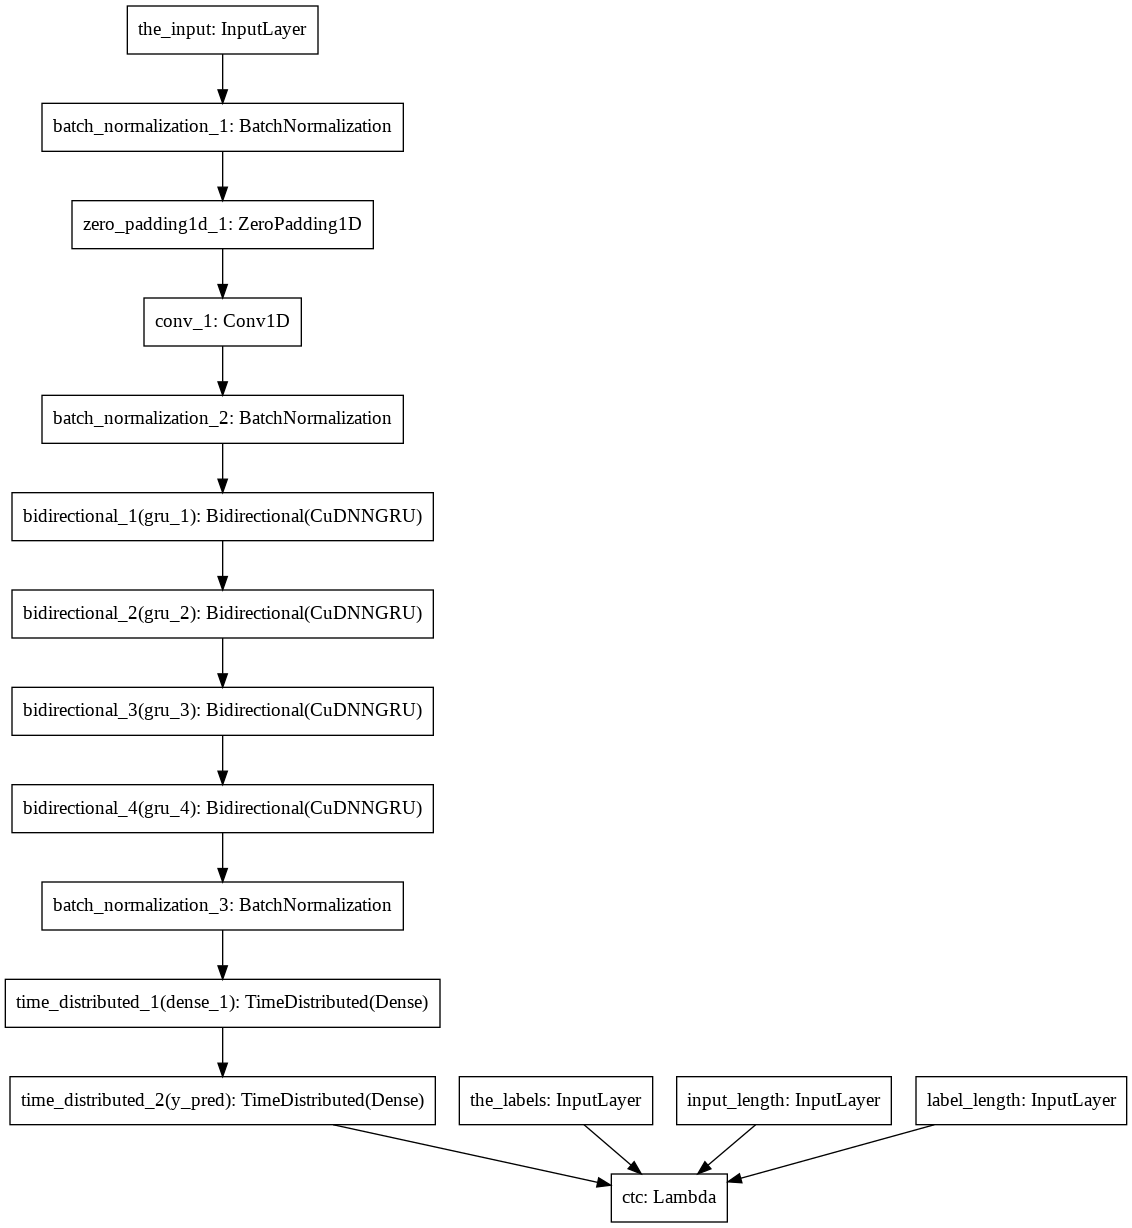

In [ ]:
plot_model(model, to_file='deepspeech_model.png', expand_nested=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 161)    644         the_input[0][0]                  
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, None, 161)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 1024)   1814528     zero_padding1d_1[0][0]           
____________________________________________________________________________________________

#Prediction

In [ ]:
#Just to show spectrogram
import librosa.display
import matplotlib.pyplot as plt

def drawSpecrogram(X_data):
  plt.figure(figsize=(45, 30))
  plt.subplot(4, 4, 1)
  #librosa.display.specshow(X_data[0].T, y_axis='log', x_axis='time')
  librosa.display.specshow(X_data[0].T, y_axis='linear')
  plt.title('Power spectrogram of original file')

In [ ]:
vIndex = 1
audio_file_name = soundfile_path + df_valid['path'][vIndex]
print(audio_file_name)
Audio(filename=audio_file_name)

/content/DeepSpeech/cv-corpus-5-singleword/ru/clips/common_voice_ru_22159794.mp3


In [ ]:
#Iterating trough all validation set
input_layer_name = 'the_input'
pred_layer_name = 'time_distributed_4'
work_model = Model(inputs=model.get_layer(input_layer_name).input,
                                 outputs=model.get_layer(pred_layer_name).output)

1/1 [==============================] - 1s 662ms/step
Prediction shape: (1, 1099, 1024)
Predicted text:  
Эй


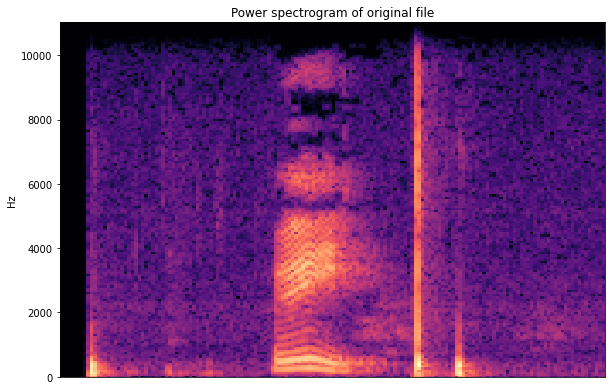

In [ ]:

result, XData, Prediction = predict(audio_file_name, work_model)
drawSpecrogram(XData)
print("Prediction shape: {0}".format(Prediction.shape))
print("Predicted text: ", result)
print(df_valid['sentence'][vIndex])

In [ ]:
#Iterating trough all validation set
#input_layer_name = 'the_input'
#pred_layer_name = 'time_distributed_2'

#work_model = Model(inputs=model.get_layer(input_layer_name).input,
#                                 outputs=model.get_layer(pred_layer_name).output)
for ind in df_valid.index:
  audio_file_name = soundfile_path + df_valid['path'][ind]
  result, _, _ = predict(audio_file_name, work_model)
  print("Predicted text: ", result)
  print("Valid text: ", df_valid['sentence'][ind])
  print("____________________________________")


1/1 [==============================] - 0s 17ms/step
Predicted text:  б
Valid text:  ноль
____________________________________
1/1 [==============================] - 0s 15ms/step
Predicted text:  
Valid text:  Эй
____________________________________
1/1 [==============================] - 0s 17ms/step
Predicted text:  
Valid text:  да
____________________________________
1/1 [==============================] - 0s 19ms/step
Predicted text:  
Valid text:  два
____________________________________


Домашнее задание

**Light:** Выкинуть из CommonVoice лажу типа шесть - шесть. Обучить сеть. Испытать другие параметры в функции ds2_gru_model

**Pro:**
1. Прочесть статью Alex Graves про CTC Loss.
2. Разобраться с кодом ноутбука.
3. Обучить на свежем CommonVoice
4. Оптимизировать функцию predict